<a href="https://colab.research.google.com/github/DavidJimenez10/CV-Deep-Learning/blob/main/ViT_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:16<00:00, 18.9MB/s]
100% 309M/309M [00:16<00:00, 19.9MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Embedding, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

import matplotlib.pyplot as plt


In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/content/dataset/Emotions Dataset/Emotions Dataset/train',
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CONFIGURATION['CLASS_NAMES'],
                                                            batch_size=CONFIGURATION['BATCH_SIZE'],
                                                            image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                            shuffle=True,
                                                            seed=99)


test_dataset = tf.keras.utils.image_dataset_from_directory('/content/dataset/Emotions Dataset/Emotions Dataset/test',
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CONFIGURATION['CLASS_NAMES'],
                                                            batch_size=CONFIGURATION['BATCH_SIZE'],
                                                            image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                            shuffle=True,
                                                            seed=99)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/100610.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image,axis=0),
                         sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'],1],
                         strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'],1],
                         rates=[1,1,1,1],
                         padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[3]))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


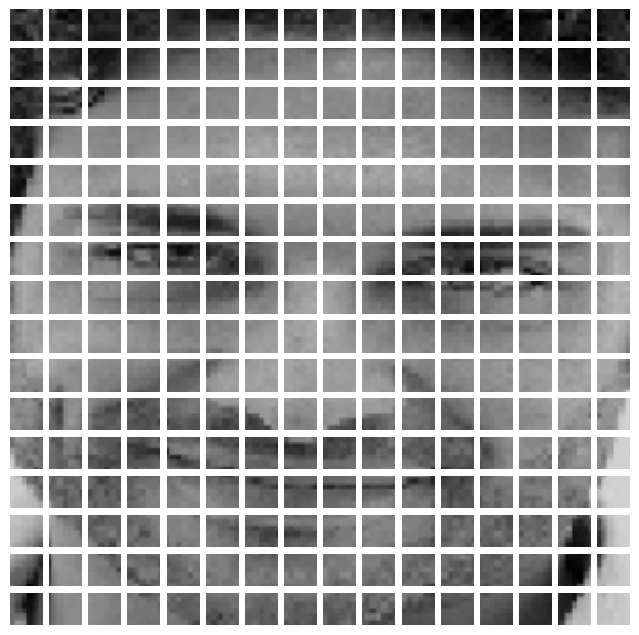

In [ ]:
plt.figure(figsize=(8,8))
for i in range(patches.shape[1]):

  ax=plt.subplot(16,16,i+1)
  plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
  plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder,self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(images=x,
                         sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'],1],
                         strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'],1],
                         rates=[1,1,1,1],
                         padding='VALID')
    patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[3]))

    embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta = 1)
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    return output


In [ ]:
patch_encoder = PatchEncoder(256,768)
patch_encoder(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.02252867,  0.00994293, -0.02749747, ..., -0.03274236,
          0.01007288, -0.03500614],
        [ 0.01082431,  0.00449326, -0.04691162, ..., -0.00516357,
         -0.02732666,  0.04501578],
        [ 0.01585731, -0.00783021, -0.00352984, ...,  0.04871216,
         -0.0300586 ,  0.01576145],
        ...,
        [ 0.03436962,  0.02477355, -0.00962967, ..., -0.03291049,
          0.00345472, -0.04608585],
        [ 0.02978463, -0.04392134,  0.02488219, ...,  0.03899207,
         -0.02857453,  0.04868772],
        [-0.02308545, -0.04688961,  0.02999913, ..., -0.04671839,
         -0.0102542 ,  0.00469297]]], dtype=float32)>

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name='transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

    self.dense_1 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output


In [ ]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name='vision_transformer')

    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]

    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')


  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for trans_encoder in self.trans_encoders:
      x = trans_encoder(x)

    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(3, 768, 256, 2, 128)
vit(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
       [0.2791631 , 0.44279113, 0.2780458 ],
      

In [ ]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  8269824   
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  8269824   
 formerEncoder)                                                  
                                                                 
 dense_8 (Dense)             multiple                  25165952  
                                                                 
 dense_9 (Dense)             multiple                  16512     
                                                

In [ ]:
vit.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = CategoricalCrossentropy(),
    metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
)


In [ ]:
history = vit.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1

)

Epoch 1/20
213/213 [==============================] - 93s 394ms/step - loss: 796.8190 - accuracy: 0.4212 - top_k_accuracy: 0.8279 - val_loss: 11.7064 - val_accuracy: 0.4706 - val_top_k_accuracy: 0.8126
Epoch 2/20
213/213 [==============================] - 85s 398ms/step - loss: 151.8318 - accuracy: 0.4195 - top_k_accuracy: 0.8584 - val_loss: 189.3328 - val_accuracy: 0.4047 - val_top_k_accuracy: 0.9219
Epoch 3/20
213/213 [==============================] - 86s 402ms/step - loss: 21.1219 - accuracy: 0.4996 - top_k_accuracy: 0.8094 - val_loss: 4.5591 - val_accuracy: 0.5198 - val_top_k_accuracy: 0.8209
Epoch 4/20
213/213 [==============================] - 86s 404ms/step - loss: 2.5669 - accuracy: 0.5877 - top_k_accuracy: 0.8510 - val_loss: 4.4593 - val_accuracy: 0.5487 - val_top_k_accuracy: 0.8025
Epoch 5/20
213/213 [==============================] - 87s 408ms/step - loss: 1.3399 - accuracy: 0.6601 - top_k_accuracy: 0.8854 - val_loss: 1.5364 - val_accuracy: 0.5689 - val_top_k_accuracy: 0.82